In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
df= pd.read_csv("./input/mnist-in-csv/mnist_train.csv")
grouped = df.groupby('label')
dflist = [grouped.get_group(i) for i in range(10)]
dflist = [df.drop(columns='label') for df in dflist]

lens = [len(dflist[i]) for i in range(10)]
print(lens)

from torch.utils.data import random_split

def digitize(n, num_digits):
    digits = list(map(int, str(n)))
    return [0] * (num_digits - len(digits)) + digits


def paoi(xmin1,ymin1,xmin2,ymin2,box_width=28,box_height=28):
    '''Percentage of Area of intersection '''
    left = max(xmin1,xmin2)
    right = min(xmin1+box_width,xmin2+box_width)
    up = min(ymin1+box_height,ymin2+box_height)
    down = max(ymin1,ymin2)
    if(left<right and down<up):
        aoi = (right-left)*(up-down)
        return(aoi/(box_width*box_height))
    else:
        return 0

def overlap_exceeded(xmins,ymins,pr_xmin,pr_ymin,box_width=28,box_height=28,max_overlap=0.4):
    ''' Checks if the proposed bounding boxes exceed the limit of intersection '''
    for xmin,ymin in zip(xmins,ymins):
            if(paoi(xmin,ymin,pr_xmin,pr_ymin,box_width,box_height)>max_overlap):
                return 1
    return 0

def ret_bounding_boxes(num_digits,H=64,W=168,box_width=28,box_height=28,max_overlap= 0.4):
    xmins =  []
    ymins =  []
    for i in range(num_digits):
        pr_xmin = np.random.randint(0,W-29)
        pr_ymin = np.random.randint(0,H-29)
        while(overlap_exceeded(xmins,ymins,pr_xmin,pr_ymin,box_width,box_height,max_overlap)):
            pr_xmin = np.random.randint(0,W-29)
            pr_ymin = np.random.randint(0,H-29)
            continue
        xmins.append(pr_xmin)
        ymins.append(pr_ymin)
    return xmins,ymins    
    
class digit_constructor(Dataset):
    def __init__(self,H,W,num_digits,dflist,dataset_size):
        self.dflist = dflist
        self.H,self.W = H,W
        self.num_digits = num_digits
        self.lens = [len(dflist[i]) for i in range(10)]
        self.number_distribution = np.random.randint(0,10**num_digits,size=dataset_size)
    def __getitem__(self,idx):
        digits = digitize(self.number_distribution[idx],self.num_digits)
        images=[]
        ## these are 28.28  images
        for digit in digits:
            choice = np.random.randint(0,self.lens[digit]-1)
            images.append(self.dflist[digit].iloc[choice].values.reshape(28,28))
        segmentation_mask = np.zeros((11,self.H,self.W))
        final_image = np.zeros((self.H,self.W))
        ## now find random boxes within the image to put the numbers in, decrease the amount of overlap.
        xmins,ymins = ret_bounding_boxes(self.num_digits,H=64,W=168,box_width=28,box_height=28,max_overlap= 0.4)
        bounding_boxes = [[xmins[i],ymins[i],xmins[i]+28,ymins[i]+28] for i in range(len(xmins))]
        for i in range(self.num_digits):
            non_zeromask = images[i]!=0 
            final_image[ymins[i]:ymins[i]+28,xmins[i]:xmins[i]+28][non_zeromask] = images[i][non_zeromask]
            segmentation_mask[digits[i],ymins[i]:ymins[i]+28,xmins[i]:xmins[i]+28] = (images[i]!=0)
        final_image = (final_image-np.mean(final_image))/np.std(final_image)

        target = {"boxes":th.tensor(bounding_boxes),"labels":th.tensor(digits)}
        return(th.tensor(final_image,dtype=th.float32).unsqueeze(0),th.tensor(segmentation_mask),
               target
               )
    def __len__(self):
        return(len(self.number_distribution))


[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


In [ ]:
import torchvision.transforms.functional as trF
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = trFReferenceError.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def draw_boxes_on_grayscale(image, boxes, colors=None, width=2):
    if image.ndimension() != 3 or image.size(0) != 1:
        raise ValueError("Input image must be a grayscale tensor of shape (1, H, W)")
    # Convert grayscale to RGB by repeating the single channel
    image_rgb = image.repeat(3, 1, 1)
    # Draw the bounding boxes
    result = draw_bounding_boxes(image_rgb, boxes, colors=colors, width=width)
    return result

def show_image_with_boxes(image_with_boxes):
    # Convert to PIL image for visualization
    result_pil = to_pil_image(image_with_boxes)
    # Plot the image
    plt.imshow(result_pil)
    plt.axis("off")
    plt.show()


# Testing my dataset and dataloader

In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT 
model = fasterrcnn_resnet50_fpn(weights=weights)

num_classes = 10
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 220MB/s] 


In [ ]:
dataset = digit_constructor(64,168,4,dflist,2000)
train_ratio = 0.8  
val_ratio = 0.2    
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Epoch 1 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.31it/s]

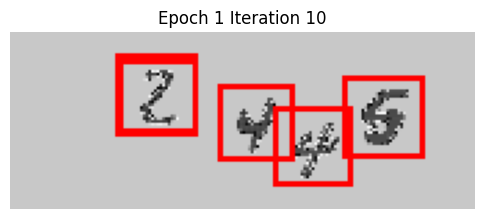

Epoch 1 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.20it/s]

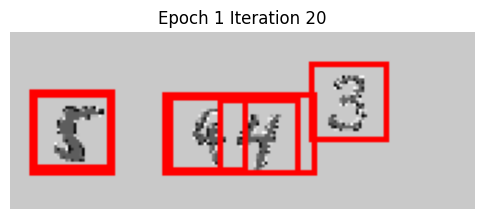

Epoch 1 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.22it/s]

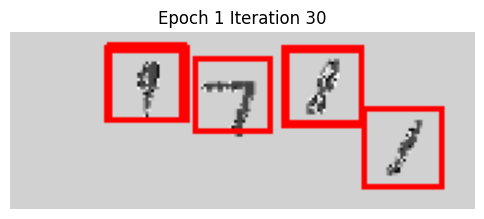

Epoch 1 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.25it/s]

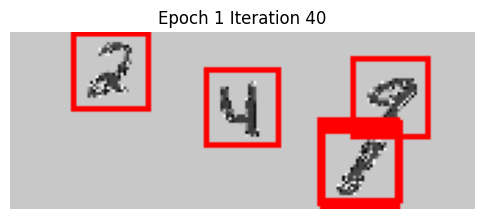

Epoch 1 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.23it/s]

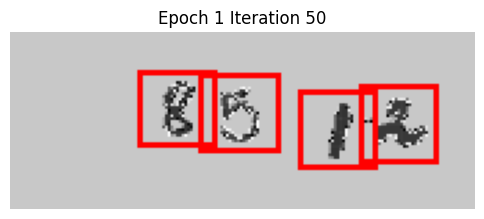

Epoch 1 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.20it/s]

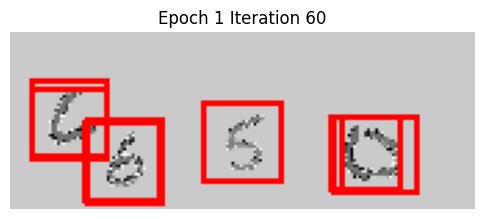

Epoch 1 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.20it/s]

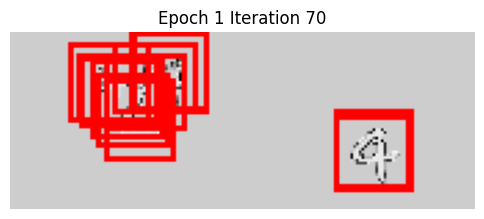

Epoch 1 [Val]:  79%|███████▉  | 79/100 [00:15<00:04,  5.23it/s]

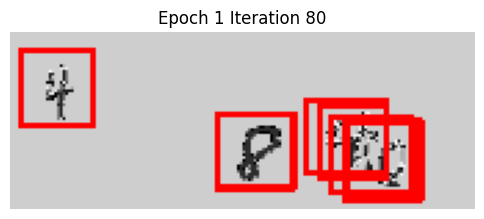

Epoch 1 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.27it/s]

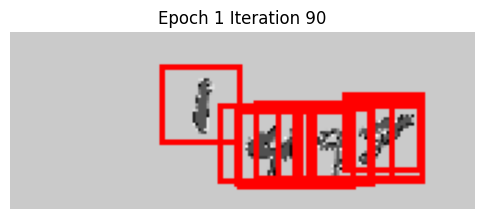

Epoch 1 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.26it/s]

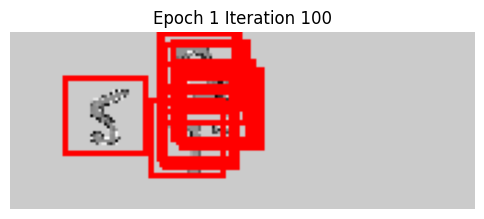

Epoch 1 [Val]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Epoch 1 finished. Avg Train Loss: 0.1015


Epoch 2 [Val]:   9%|▉         | 9/100 [00:01<00:16,  5.37it/s]

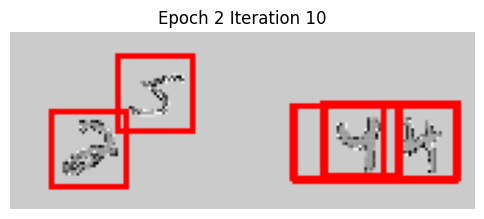

Epoch 2 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.29it/s]

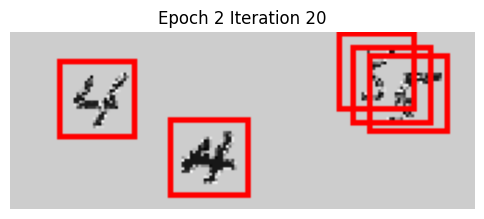

Epoch 2 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.29it/s]

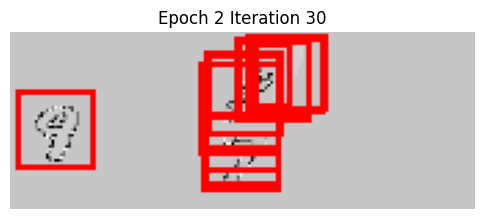

Epoch 2 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.29it/s]

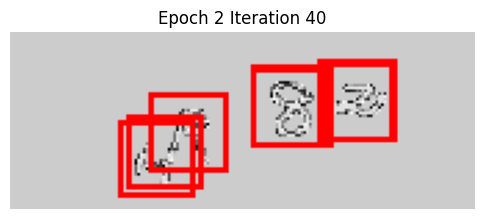

Epoch 2 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.28it/s]

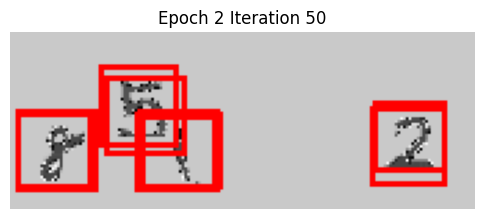

Epoch 2 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.31it/s]

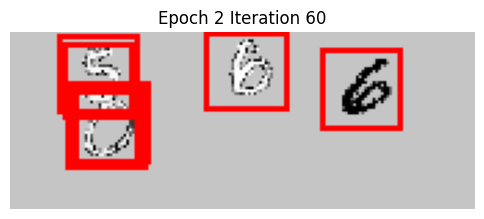

Epoch 2 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.24it/s]

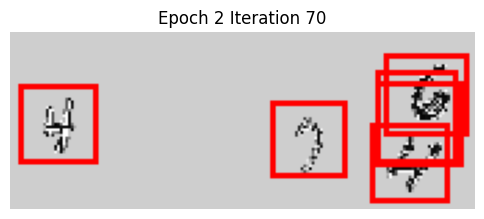

Epoch 2 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.25it/s]

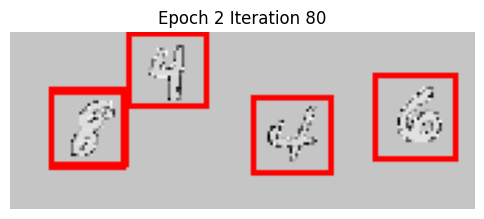

Epoch 2 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.27it/s]

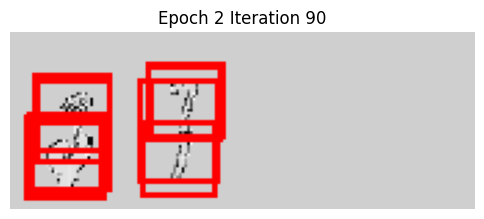

Epoch 2 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.30it/s]

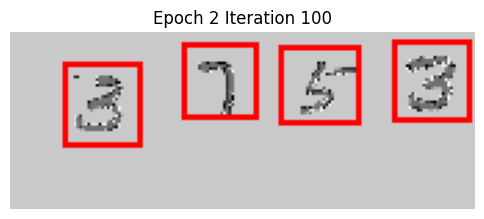

Epoch 2 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Epoch 2 finished. Avg Train Loss: 0.0703


Epoch 3 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.33it/s]

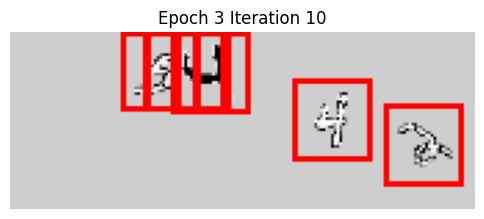

Epoch 3 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.28it/s]

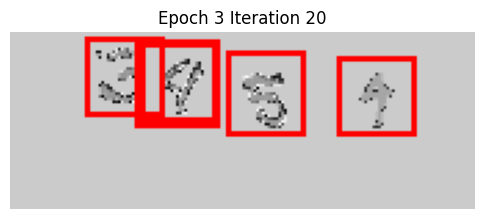

Epoch 3 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.26it/s]

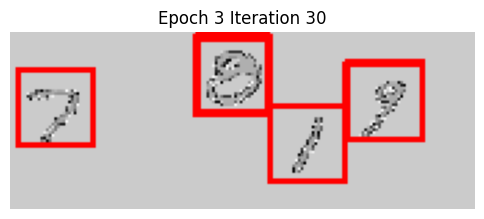

Epoch 3 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.27it/s]

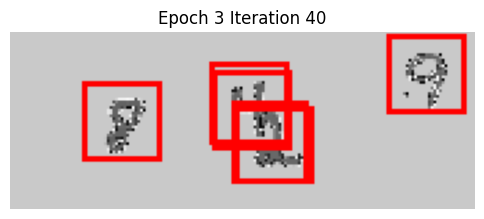

Epoch 3 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.28it/s]

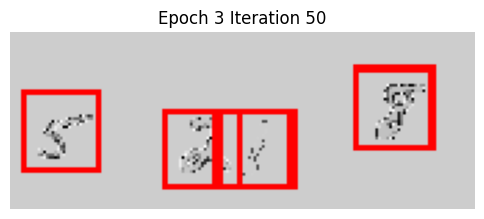

Epoch 3 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.31it/s]

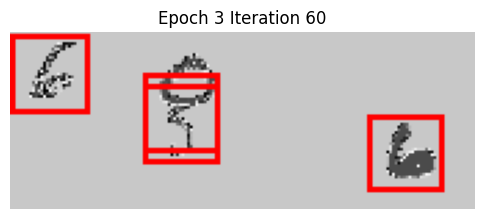

Epoch 3 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.31it/s]

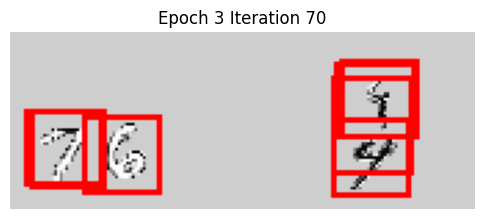

Epoch 3 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.32it/s]

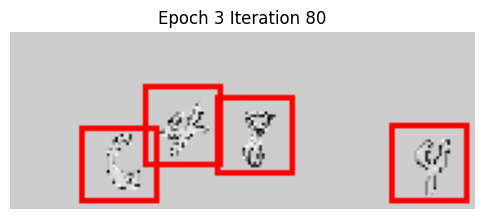

Epoch 3 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.20it/s]

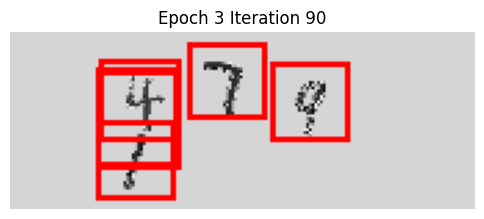

Epoch 3 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.21it/s]

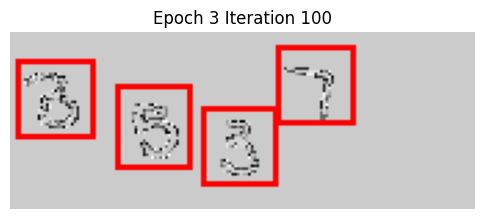

Epoch 3 [Val]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Epoch 3 finished. Avg Train Loss: 0.0591


Epoch 4 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.33it/s]

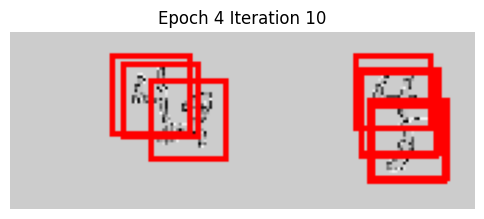

Epoch 4 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.30it/s]

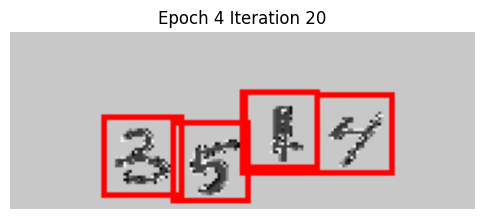

Epoch 4 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.27it/s]

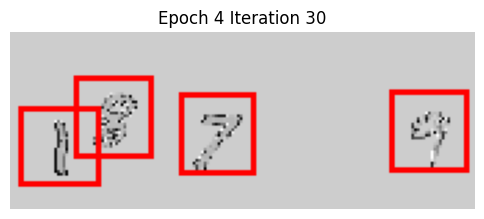

Epoch 4 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.27it/s]

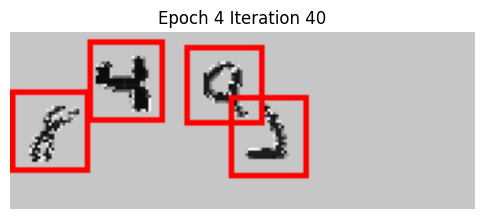

Epoch 4 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.32it/s]

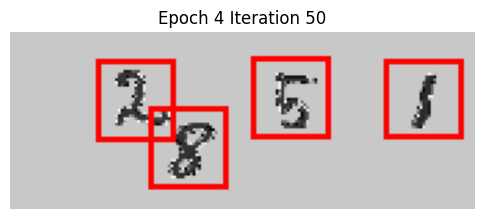

Epoch 4 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.25it/s]

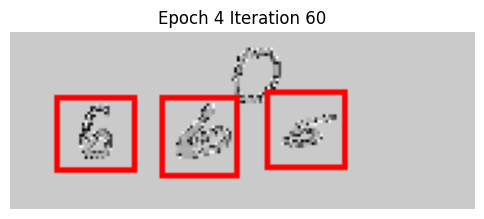

Epoch 4 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.23it/s]

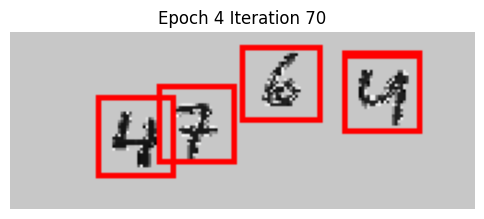

Epoch 4 [Val]:  79%|███████▉  | 79/100 [00:15<00:04,  5.25it/s]

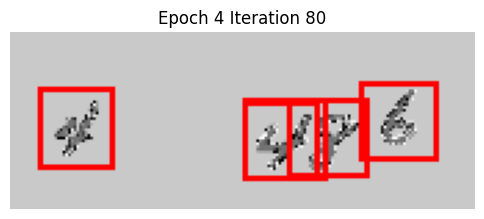

Epoch 4 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.31it/s]

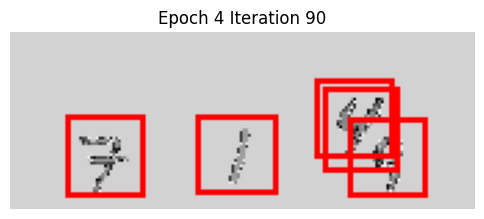

Epoch 4 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.29it/s]

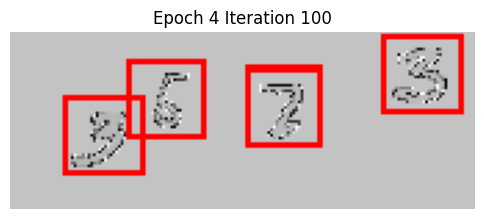

Epoch 4 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Epoch 4 finished. Avg Train Loss: 0.0493


Epoch 5 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.34it/s]

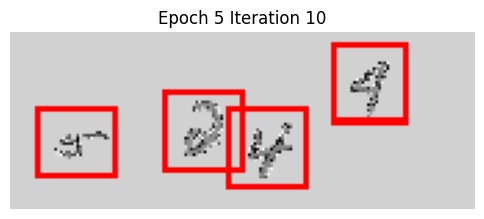

Epoch 5 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.32it/s]

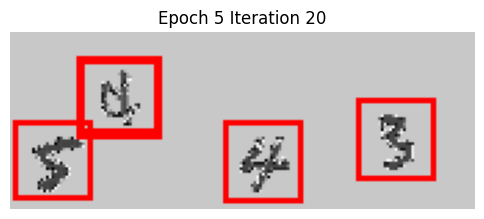

Epoch 5 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.30it/s]

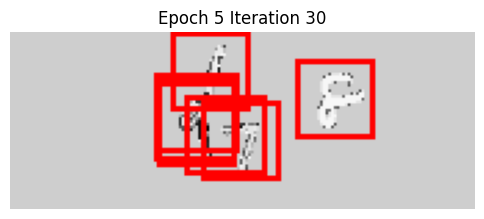

Epoch 5 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.28it/s]

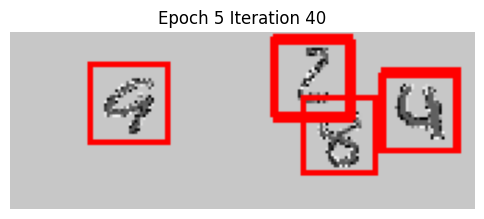

Epoch 5 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.32it/s]

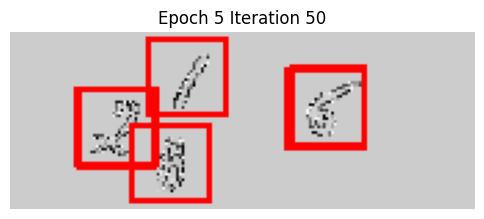

Epoch 5 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.29it/s]

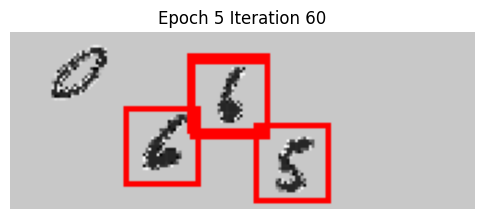

Epoch 5 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.31it/s]

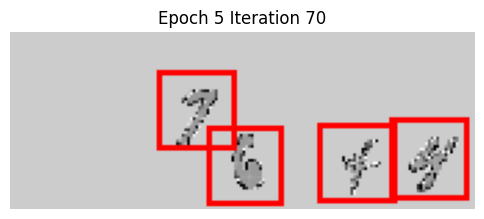

Epoch 5 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.30it/s]

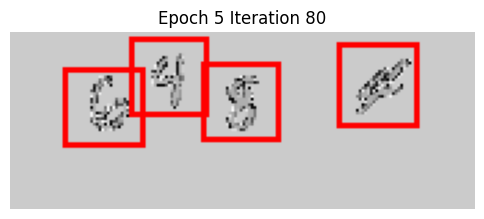

Epoch 5 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.29it/s]

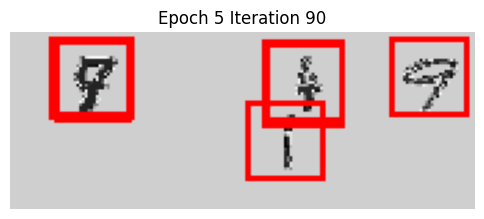

Epoch 5 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.31it/s]

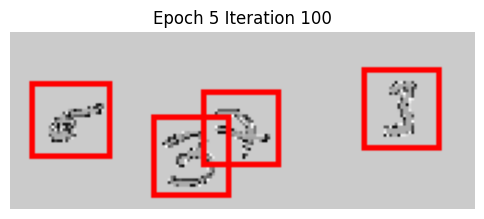

Epoch 5 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Epoch 5 finished. Avg Train Loss: 0.0444


Epoch 6 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.33it/s]

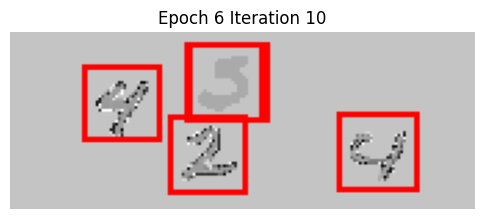

Epoch 6 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.30it/s]

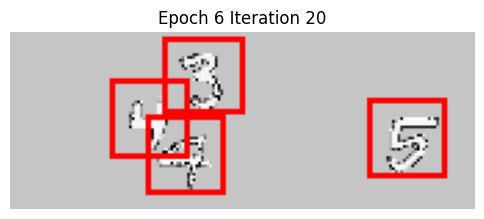

Epoch 6 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.30it/s]

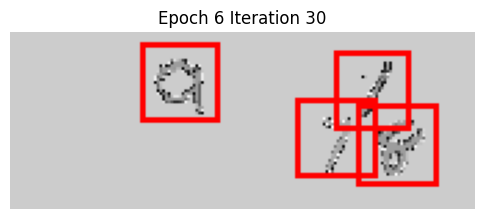

Epoch 6 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.28it/s]

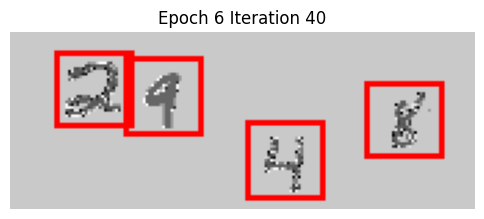

Epoch 6 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.30it/s]

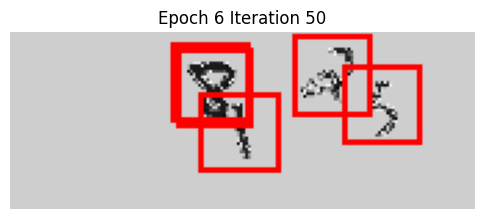

Epoch 6 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.30it/s]

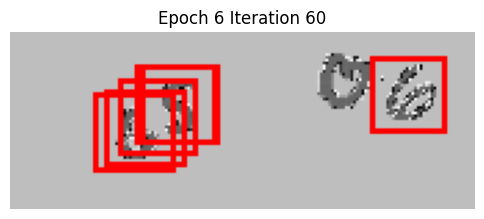

Epoch 6 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.29it/s]

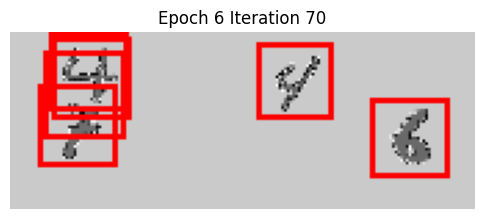

Epoch 6 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.28it/s]

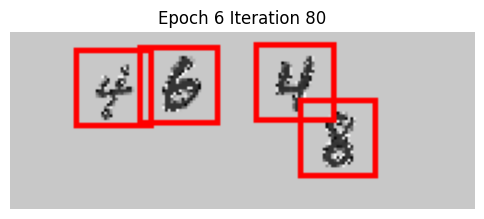

Epoch 6 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.28it/s]

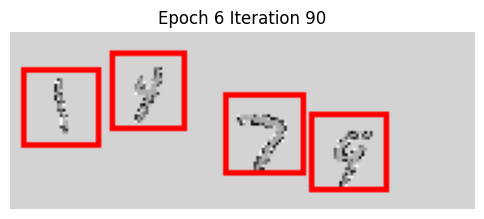

Epoch 6 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.29it/s]

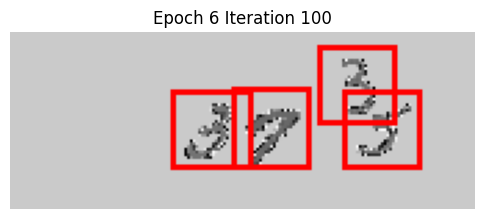

Epoch 6 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Epoch 6 finished. Avg Train Loss: 0.0403


Epoch 7 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.35it/s]

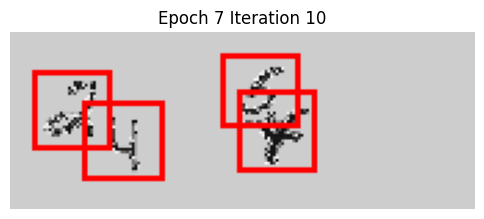

Epoch 7 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.31it/s]

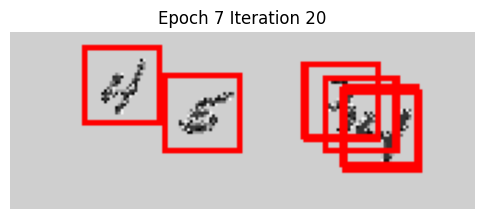

Epoch 7 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.29it/s]

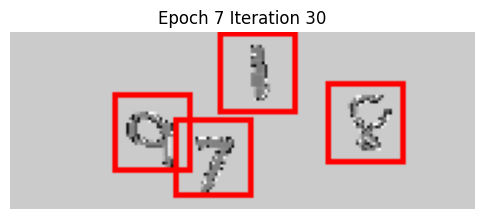

Epoch 7 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.29it/s]

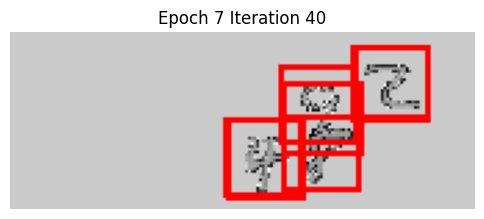

Epoch 7 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.29it/s]

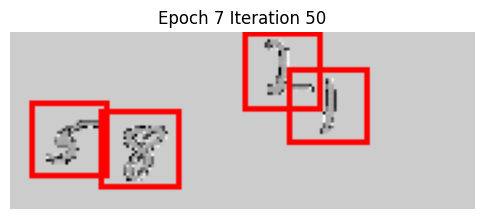

Epoch 7 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.32it/s]

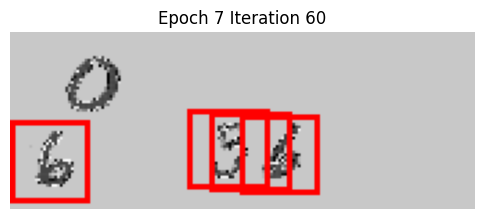

Epoch 7 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.24it/s]

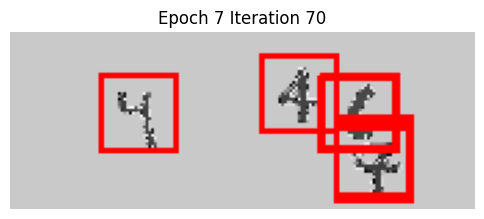

Epoch 7 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.29it/s]

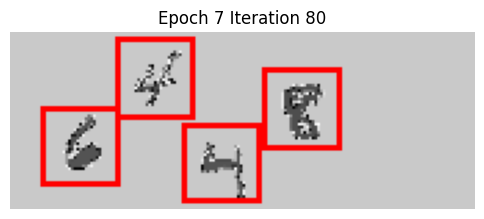

Epoch 7 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.25it/s]

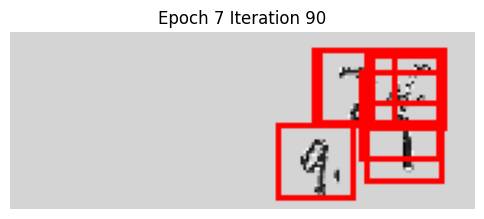

Epoch 7 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.28it/s]

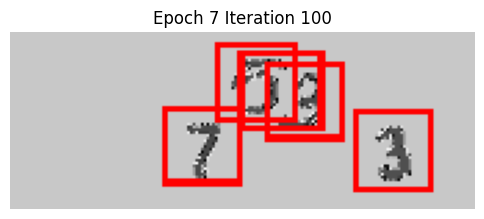

Epoch 7 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Epoch 7 finished. Avg Train Loss: 0.0374


Epoch 8 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.34it/s]

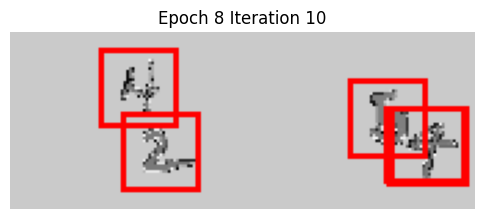

Epoch 8 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.32it/s]

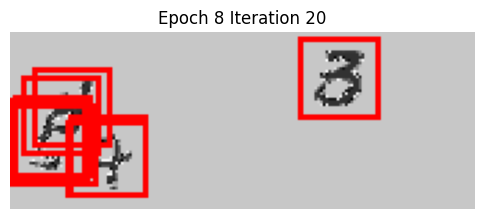

Epoch 8 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.24it/s]

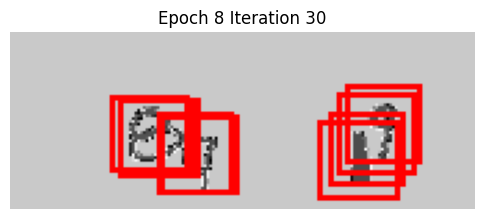

Epoch 8 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.27it/s]

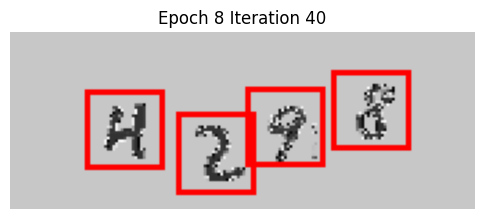

Epoch 8 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.22it/s]

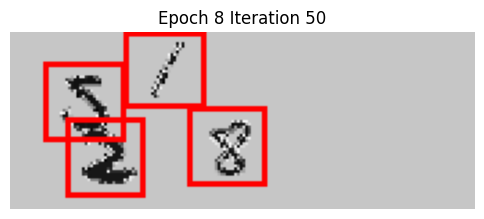

Epoch 8 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.26it/s]

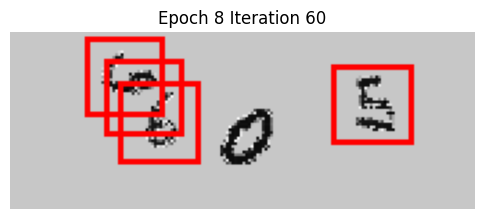

Epoch 8 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.25it/s]

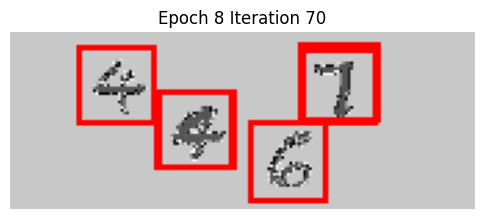

Epoch 8 [Val]:  79%|███████▉  | 79/100 [00:15<00:04,  5.23it/s]

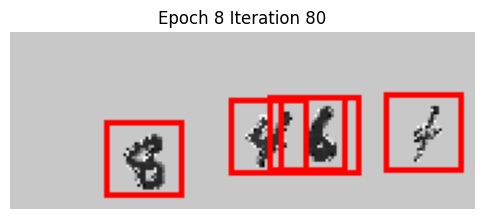

Epoch 8 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.30it/s]

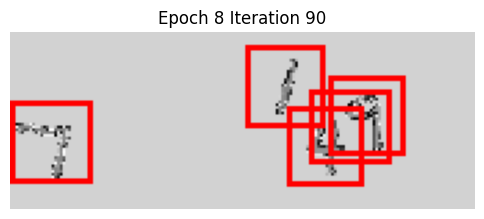

Epoch 8 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.30it/s]

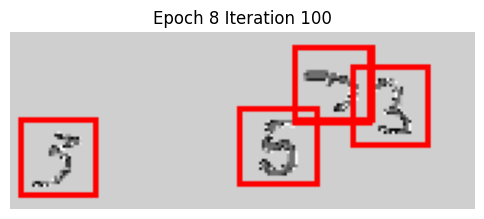

Epoch 8 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Epoch 8 finished. Avg Train Loss: 0.0350


Epoch 9 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.32it/s]

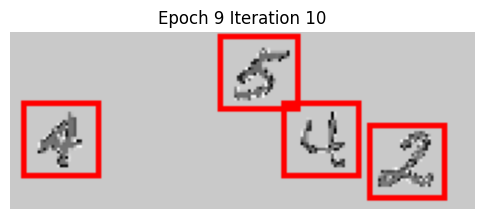

Epoch 9 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.28it/s]

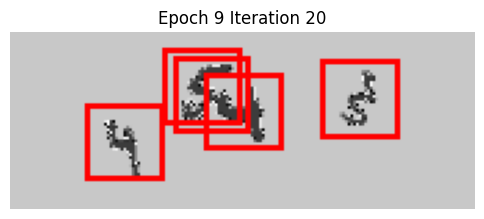

Epoch 9 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.30it/s]

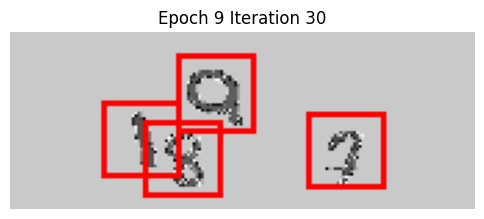

Epoch 9 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.32it/s]

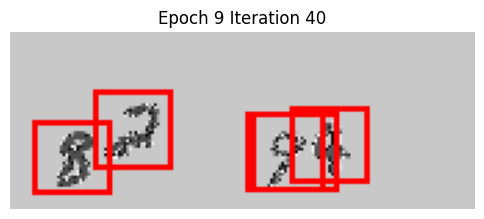

Epoch 9 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.29it/s]

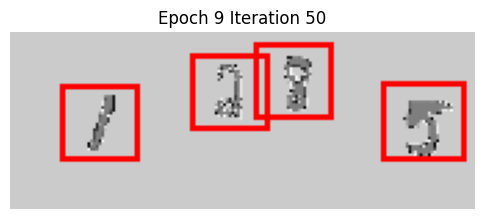

Epoch 9 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.29it/s]

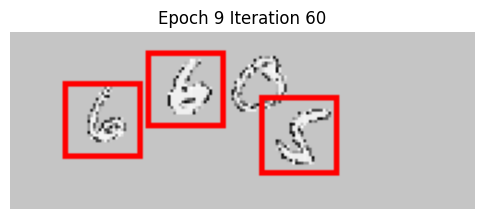

Epoch 9 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.29it/s]

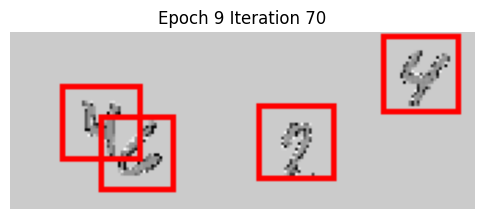

Epoch 9 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.29it/s]

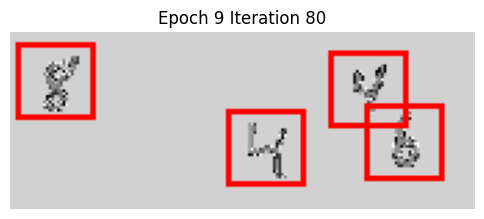

Epoch 9 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.29it/s]

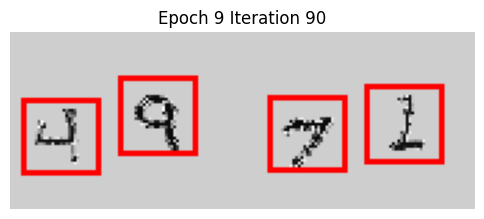

Epoch 9 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.26it/s]

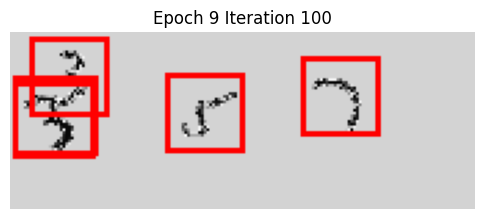

Epoch 9 [Val]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Epoch 9 finished. Avg Train Loss: 0.0328


Epoch 10 [Val]:   9%|▉         | 9/100 [00:01<00:17,  5.26it/s]

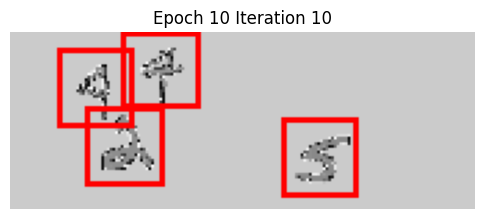

Epoch 10 [Val]:  19%|█▉        | 19/100 [00:03<00:15,  5.28it/s]

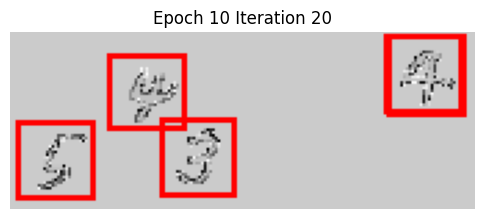

Epoch 10 [Val]:  29%|██▉       | 29/100 [00:05<00:13,  5.27it/s]

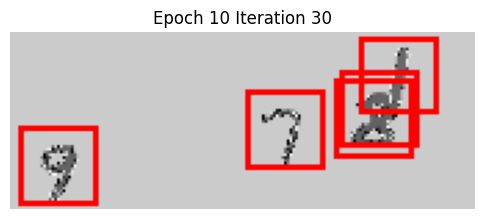

Epoch 10 [Val]:  39%|███▉      | 39/100 [00:07<00:11,  5.33it/s]

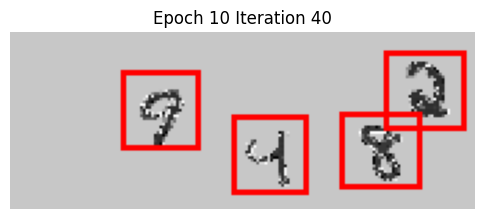

Epoch 10 [Val]:  49%|████▉     | 49/100 [00:09<00:09,  5.29it/s]

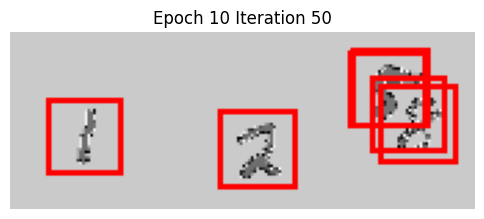

Epoch 10 [Val]:  59%|█████▉    | 59/100 [00:11<00:07,  5.31it/s]

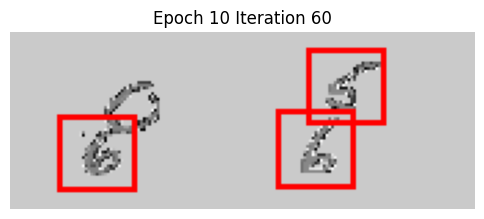

Epoch 10 [Val]:  69%|██████▉   | 69/100 [00:13<00:05,  5.26it/s]

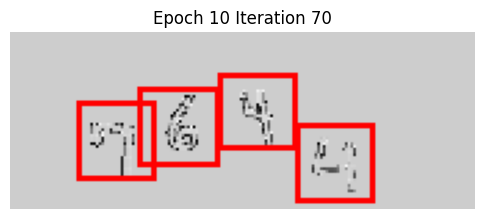

Epoch 10 [Val]:  79%|███████▉  | 79/100 [00:15<00:03,  5.28it/s]

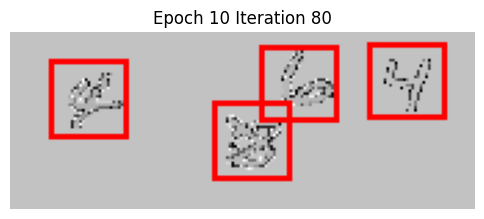

Epoch 10 [Val]:  89%|████████▉ | 89/100 [00:17<00:02,  5.30it/s]

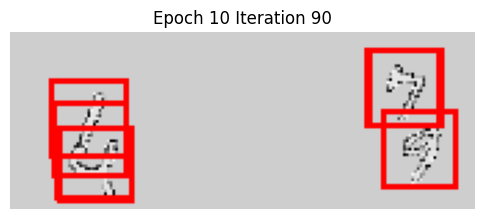

Epoch 10 [Val]:  99%|█████████▉| 99/100 [00:19<00:00,  5.31it/s]

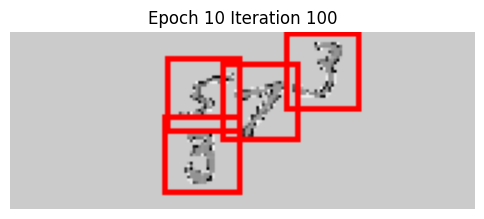

Epoch 10 [Val]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]

Epoch 10 finished. Avg Train Loss: 0.0320


In [ ]:
import torch.optim as optim
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torch as th

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")
    for images, masks, targets in train_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_bar.set_postfix(loss=losses.item())
    avg_train_loss = running_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0
    iteration = 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")
        for images, masks, targets in val_bar:
            images = [img.to(device) for img in images]
            predictions = model(images)  
            iteration += 1
            if iteration % 10 == 0:
                # Get predictions for the first image in the batch
                pred = predictions[0]
                boxes = pred['boxes'].detach().cpu().to(torch.int)
                img = images[0].detach().cpu()
                if img.shape[0] == 1:
                    img = img.repeat(3, 1, 1)
                drawn = draw_bounding_boxes(img, boxes, colors="red", width=2)
                plt.figure(figsize=(6,6))
                plt.imshow(to_pil_image(drawn))
                plt.title(f"Epoch {epoch+1} Iteration {iteration}")
                plt.axis("off")
                plt.show()
    print(f"Epoch {epoch+1} finished. Avg Train Loss: {avg_train_loss:.4f}")


In [ ]:
th.save(model.state_dict(),"digit_detection.pt")